This notebook demonstrates use of our linear approximation for a multiplicative functional perturbation 

In [1]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
from bnpmodeling_runjingdev import modeling_lib 
import bnpgmm_runjingdev.functional_sensitivity_lib as fun_sens_lib 
from bnpgmm_runjingdev import utils_lib
from bnpmodeling_runjingdev import optimization_lib 
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles
from tqdm import tqdm

import json 

/home/rgiordan/Documents/git_repos/BNP_sensitivity/GMM_clustering/venv/lib/python3.5/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

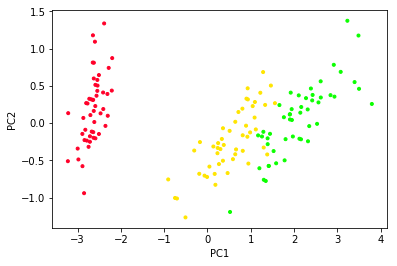

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'prior_centroid_mean': array([0.]), 'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'alpha': array([3.])}


In [7]:
# DP prior parameter 
prior_params_dict['alpha'] = 12

### Variational parameters

In [8]:
k_approx = 30

In [9]:
# Gauss-Hermite points
gh_deg = 20
gh_loc, gh_weights = hermgauss(gh_deg)


In [10]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [11]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1726.545646040481

# Optimize

### Kmeans

In [12]:
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 32423)

### Newton

### Set up KL objective as a function of unconstrained VB parameters

In [13]:
# get loss as a function of vb parameters
def get_vb_params_loss(params):
    return gmm_lib.get_kl(features, params, prior_params_dict,
                                gh_loc, gh_weights)

# paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
# get_vb_params_loss.cache_args(features, None, prior_params_dict,
#                                 gh_loc, gh_weights)

# Get loss as a function vb_free_params
get_loss = paragami.FlattenFunctionInput(original_fun=get_vb_params_loss,
                                        patterns=vb_params_paragami,
                                        free=True)


In [14]:
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 764.09420271
Iter 1: f = 597.19796043
Iter 2: f = 466.21787197
Iter 3: f = 1087.06177347
Iter 4: f = 419.49158187
Iter 5: f = 369.96099757
Iter 6: f = 324.50284029
Iter 7: f = 269.56811060
Iter 8: f = 254.00028219
Iter 9: f = 227.43781552
Iter 10: f = 185.58440500
Iter 11: f = 134.25668549
Iter 12: f = 68.22861692
Iter 13: f = 56.10407209
Iter 14: f = 33.56616221
Iter 15: f = -4.96369633
Iter 16: f = -52.80849166
Iter 17: f = -89.47795655
Iter 18: f = -9.47163148
Iter 19: f = -97.92520728
Iter 20: f = -111.21669822
Iter 21: f = -119.51435034
Iter 22: f = -132.59262491
Iter 23: f = -147.24832894
Iter 24: f = -166.02791237
Iter 25: f = -172.64290487
Iter 26: f = -180.60253201
Iter 27: f = -189.86811024
Iter 28: f = -202.48716343
Iter 29: f = -214.25160522
Iter 30: f = -217.07327299
Iter 31: f = -221.94554797
Iter 32: f = -229.16574069
Iter 33: f = -236.18675817
Iter 34: f = -239.24620710
Iter 35: f = -243.07006727
Iter 36: f = -247.45893047
Iter 37: f = -252

Iter 298: f = -310.09557526
Iter 299: f = -310.10127450
Iter 300: f = -310.04961219
Iter 301: f = -310.10855871
Iter 302: f = -310.10990171
Iter 303: f = -309.78443207
Iter 304: f = -310.11091218
Iter 305: f = -310.11296422
Iter 306: f = -310.12121948
Iter 307: f = -310.13847998
Iter 308: f = -310.18821426
Iter 309: f = -310.27336410
Iter 310: f = -310.30032358
Iter 311: f = -310.34293039
Iter 312: f = -310.34357576
Iter 313: f = -310.36459848
Iter 314: f = -310.38071514
Iter 315: f = -310.37869778
Iter 316: f = -310.38752034
Iter 317: f = -310.39475051
Iter 318: f = -310.40298071
Iter 319: f = -310.39813575
Iter 320: f = -310.40518969
Iter 321: f = -310.40807932
Iter 322: f = -310.40936398
Iter 323: f = -310.40967816
Iter 324: f = -310.41011895
Iter 325: f = -310.41068355
Iter 326: f = -310.41089015
Iter 327: f = -310.41058745
Iter 328: f = -310.41094386
Iter 329: f = -310.41103109
Iter 330: f = -310.41114619
Iter 331: f = -310.41105665
Iter 332: f = -310.41117258
Iter 333: f = -310.4

In [15]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


In [16]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

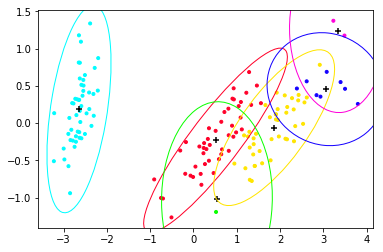

In [17]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)

# Define a perturbation in the logit v space.

In [18]:
def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [19]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 10 * log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [20]:
prior_perturbation = fun_sens_lib.PriorPerturbation(
    vb_params_dict = vb_opt_dict, 
    alpha0 = prior_params_dict['alpha'],
    gh_loc = gh_loc, 
    gh_weights = gh_weights, 
    log_phi = rescaled_log_phi, logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-2.4849066497879995 1.1634968823127927 -2.4889315240780148 1.1662640532746475


Text(0.5, 1.0, 'Priors in logit space')

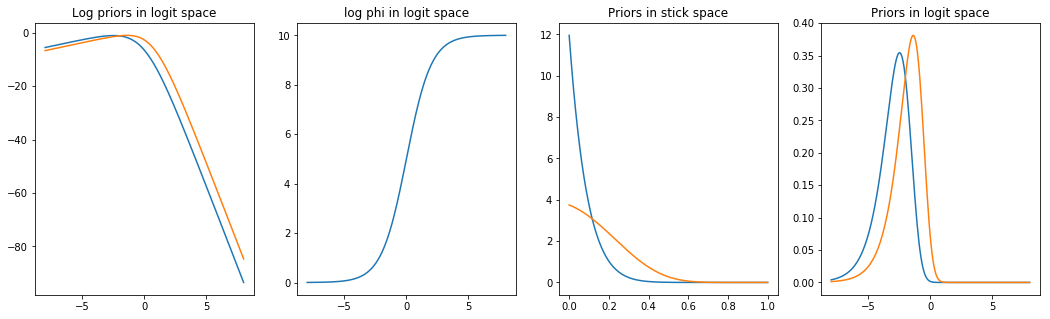

In [21]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


# Define prior perturbation

In [22]:
# epsilon_param_dict = {'epsilon': np.array([1.0])}

# epsilon_param_paragami = paragami.PatternDict() 
# epsilon_param_paragami['epsilon'] = \
#         paragami.NumericArrayPattern(shape=(1, ))

In [23]:
# we will use this for the sensitivity class
get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: fun_sens_lib.get_perturbed_kl(
        features, params, epsilon, rescaled_log_phi, 
        prior_params_dict, gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)
    
hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: fun_sens_lib.get_e_log_perturbation(
        rescaled_log_phi, params, epsilon, gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

#     = paragami.Functor(
#     original_fun=fun_sens_lib.get_perturbed_kl, argnums=[1, 2])

# # the kl as a function of both the vb parameters and the hyperparameter
# get_epsilon_vb_loss.cache_args(features, None, None, rescaled_log_phi, 
#                      prior_params_dict, gh_loc, gh_weights)

# # the only part of the kl that depends on epsilon
# def hyper_par_objective_fun(params, epsilon):
#     return fun_sens_lib.get_e_log_perturbation(
#         rescaled_log_phi, params, epsilon, gh_loc, gh_weights),


# # hyper_par_objective_fun = \
# #     paragami.Functor(fun_sens_lib.get_e_log_perturbation, argnums = [1, 2])
    
# # hyper_par_objective_fun.cache_args(rescaled_log_phi, None, None, 
# #                            gh_loc, gh_weights)

In [24]:
# Compute hyper sensitivity object
# epsilon_sens = \
#     vittles.HyperparameterSensitivityLinearApproximation(
#         objective_fun=           get_epsilon_vb_loss,
#         opt_par_pattern=         vb_params_paragami,
#         hyper_par_pattern=       epsilon_param_paragami,
#         opt_par_folded_value=    vb_params_paragami.fold(vb_opt, free = True),
#         hyper_par_folded_value=  epsilon_param_paragami.fold(0.0, free = False),
#         opt_par_is_free=         True,
#         hyper_par_is_free=       False,
#         hyper_par_objective_fun = hyper_par_objective_fun,
#         grad_tol=                1e-5)


epsilon_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        objective_function =               get_epsilon_vb_loss,
        hyper_par_objective_function =     hyper_par_objective_fun,
        input_val0 = vb_opt,
        hyper_val0 = np.array([0]),
        order = 1)

/home/rgiordan/Documents/git_repos/BNP_sensitivity/GMM_clustering/venv/lib/python3.5/site-packages/vittles/sensitivity_lib.py:857: UserWarning: The ParametricSensitivityTaylorExpansion is experimental.
  'The ParametricSensitivityTaylorExpansion is experimental.')


## Fit with perturbation

In [27]:
epsilon = 1.0 
print('Epsilon: ', epsilon)

vb_pert_pred = epsilon_sens.evaluate_taylor_series(epsilon)

print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))

Epsilon:  1.0
Predicted differences:  3.7833885423010343


In [28]:
vb_pert_pred_dict = vb_params_paragami.fold(vb_pert_pred, free = True)
e_z_pert_pred = gmm_lib.get_optimal_z_from_vb_params_dict(
    features, vb_pert_pred_dict, gh_loc, gh_weights)

In [46]:
# get flattened perturbed KL
def get_loss_for_epsilon(epsilon):
    get_perturbed_vb_loss_flattened = paragami.FlattenFunctionInput(
        lambda params: 
            fun_sens_lib.get_perturbed_kl(
                features, params, epsilon, rescaled_log_phi, 
                 prior_params_dict, gh_loc, gh_weights),
        argnums=0,
        patterns=vb_params_paragami,
        free=True)
    return get_perturbed_vb_loss_flattened

get_perturbed_vb_loss_flattened = get_loss_for_epsilon(epsilon)
# get_perturbed_vb_loss = paragami.Functor(
#     original_fun=fun_sens_lib.get_perturbed_kl, argnums=[1])

# get_perturbed_vb_loss.cache_args(features, None, epsilon_param_dict, rescaled_log_phi, 
#                      prior_params_dict, gh_loc, gh_weights)

# get_perturbed_vb_loss_flattened = \
#     paragami.FlattenedFunction(original_fun=get_perturbed_vb_loss,
#                                 patterns=vb_params_paragami,
#                                 free=True)


In [36]:
vb_pert_opt = optimization_lib.optimize_full(
    get_perturbed_vb_loss_flattened,
    deepcopy(vb_opt),
    bfgs_max_iter = 500, netwon_max_iter = 50,
    max_precondition_iter = 10,
    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = -344.63255894
Iter 1: f = -344.89526832
Iter 2: f = -346.13126161
Iter 3: f = -326.19366675
Iter 4: f = -346.23045953
Iter 5: f = -346.39670228
Iter 6: f = -346.69606106
Iter 7: f = -347.07719821
Iter 8: f = -347.47084396
Iter 9: f = -347.64468061
Iter 10: f = -347.94000533
Iter 11: f = -348.29422929
Iter 12: f = -348.32188375
Iter 13: f = -348.48110045
Iter 14: f = -348.81473289
Iter 15: f = -349.21650230
Iter 16: f = -349.57933815
Iter 17: f = -350.08524499
Iter 18: f = -350.32878250
Iter 19: f = -350.73826395
Iter 20: f = -351.34476969
Iter 21: f = -351.67681088
Iter 22: f = -352.05474054
Iter 23: f = -351.73329457
Iter 24: f = -352.18850215
Iter 25: f = -352.34376506
Iter 26: f = -352.55022697
Iter 27: f = -352.81909118
Iter 28: f = -353.16792166
Iter 29: f = -351.97473367
Iter 30: f = -353.23377368
Iter 31: f = -353.30295717
Iter 32: f = -353.41696363
Iter 33: f = -353.38897435
Iter 34: f = -353.46810541
Iter 35: f = -353.54141712
Iter 36: f = -353.57

In [37]:
vb_pert_opt_dict = vb_params_paragami.fold(vb_pert_opt, free = True)
e_z_pert_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_opt_dict, gh_loc, gh_weights)

Epsilon: 1.0


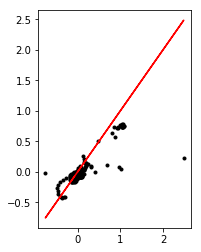

In [38]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vb_pert_opt - vb_opt, vb_pert_pred - vb_opt, 'k.')
plt.plot(vb_pert_opt - vb_opt, vb_pert_opt - vb_opt, 'r')


In [39]:
print('original expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_opt_dict['stick_propn_mean'], 
                                                        vb_opt_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('perturbed expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_opt_dict['stick_propn_mean'], 
                                                        vb_pert_opt_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('predicted expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_pred_dict['stick_propn_mean'], 
                                                        vb_pert_pred_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))


      

original expected number of clusters:  14.647020994660052
perturbed expected number of clusters:  12.759733585453187
predicted expected number of clusters:  12.6119488775268


# Predict for a range of perturbations

In [40]:
# The range of epsilons we shall consider
epsilon_vec = np.linspace(0, 1, 6) ** 2 # Square to get more points close to 0
print(epsilon_vec)

[0.   0.04 0.16 0.36 0.64 1.  ]


In [47]:
def refit_with_epsilon(epsilon, init_vb_opt):
    # sets new epsilon, returns new vb optimum

    get_perturbed_vb_loss_flattened = get_loss_for_epsilon(epsilon)

    # optimize
    vb_opt_pert = optimization_lib.optimize_full(
        get_perturbed_vb_loss_flattened, deepcopy(init_vb_opt),
        bfgs_max_iter = 0, netwon_max_iter = 50,
        max_precondition_iter = 10,
        gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

In [48]:
best_param_phi_array = []
best_param_phi_pred_array = []

In [50]:
vb_pert_opt_array = []
vb_pert_pred_array = []


for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    vb_pert_pred = \
        epsilon_sens.evaluate_taylor_series(epsilon)

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    
    # Then fit with the perturbation.
    vb_pert_opt = refit_with_epsilon(epsilon, vb_opt)
    
    print('Done. ')

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(vb_pert_opt - vb_opt))
    
    # save results: 
    vb_pert_opt_array.append(vb_pert_opt)
    vb_pert_pred_array.append(vb_pert_pred)
    




Epsilon:  0.0
Predicted differences:  0.0

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 14.81
running newton steps
Optimization terminated successfully.
Iter 0: f = -310.48627870
         Current function value: -310.486279
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 0: x_diff = 1.1633554362899812e-12, f_diff = 2.2168933355715126e-12, grad_l1 = 1.8138492378154736e-10
done. 
Done. 
Predicted differences:  0.0
Actual differences: (This is nonzero if phi did anything): 1.2005722984450163e-13


Epsilon:  0.04000000000000001
Predicted differences:  0.15133554169204133

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 14.98
running newton steps
Iter 0: f = -311.85212991
Iter 1: f = -311.86273959
Iter 2: f = -311.86274167
Iter 3: f = -311.86274167
Iter 4: f = -311.86274167
         Current function

# Lets look at the expected number of clusters

### Number of in sample clusters

In [51]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(
        features, vb_params_paragami, 
        vb_pert_pred_array[i],
        gh_loc, gh_weights,
        threshold = threshold,
        n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(
        features, vb_params_paragami, 
        vb_pert_opt_array[i],
        gh_loc, gh_weights,
        threshold = threshold,
        n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


100%|██████████| 6/6 [00:17<00:00,  2.98s/it]


In [ ]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))


### Number of predicted clusters

In [ ]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_pred_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_opt_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


In [ ]:
plt.plot(epsilon_vec, lr_e_num_pred_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))